In [1]:
%pip install llama-index


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install llama-index-embeddings-huggingface


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install replicate


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install gdsfactory


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
%pip install llama-index-llms-replicate


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [6]:
import os
from llama_index.core import (
    SimpleDirectoryReader,
    ServiceContext,
)
from llama_index.llms.replicate import Replicate
from llama_index.core.graph_stores import SimpleGraphStore
from llama_index.core import StorageContext


"""

Other language models supported by replicate:

google gemma: google-deepmind/gemma-7b-it:2790a695e5dcae15506138cc4718d1106d0d475e6dca4b1d43f42414647993d5
llama2-70B: andreasjansson/sheep-duck-llama-2-70b-v1-1-gguf:a8d46304cdc3e0b4f18773b2863a0bf24a1daa7fd43e9e94f6d7f197a759152b
codellama-70B: meta/codellama-70b-python:338f2fc1036f847626d0905c1f4fbe6d6d287a476c655788b3f1f27b1a78dab2
codellama-34B: meta/codellama-34b-instruct:eeb928567781f4e90d2aba57a51baef235de53f907c214a4ab42adabf5bb9736
meta/llama-2-70b-chat
mistralai/mixtral-8x7b-instruct-v0.1

"""


os.environ["REPLICATE_API_TOKEN"] = "ENTER REPLICATE_API_TOKEN HERE"


llm = Replicate(
    model="mistralai/mixtral-8x7b-instruct-v0.1",
    is_chat_model=True,
    additional_kwargs={"max_new_tokens": 512}
)


service_context = ServiceContext.from_defaults(llm=llm, embed_model="local:BAAI/bge-small-en-v1.5")


graph_store = SimpleGraphStore()
storage_context = StorageContext.from_defaults(graph_store=graph_store)


/var/folders/0t/85tdrsb92jd7c29p9mjcj1lw0000gn/T/ipykernel_32823/3037179394.py:35: DeprecationWarning: Call to deprecated class method from_defaults. (ServiceContext is deprecated, please use `llama_index.settings.Settings` instead.) -- Deprecated since version 0.10.0.
  service_context = ServiceContext.from_defaults(llm=llm, embed_model="local:BAAI/bge-small-en-v1.5")


In [7]:
from llama_index.core import SQLDatabase
from sqlalchemy import create_engine
from llama_index.core.query_engine import NLSQLTableQueryEngine

engine = create_engine("sqlite:///Devices-simulation.db", future=True)
with engine.connect() as connection:
    cursor = connection.exec_driver_sql('''SELECT * FROM DevicesTable ''')
    print(cursor.fetchall())

sql_database = SQLDatabase(engine, include_tables=["DevicesTable"])

sql_query_engine = NLSQLTableQueryEngine(
    sql_database=sql_database,
    tables=["DevicesTable"],
)

[(1, 'MMI 1x2', 'Width_MMI=3.8', 'Length_MMI=12.8', 'Gap_MMI=0.25', 'Taper_Length=10.0', 'Taper_Width=1.4', None, '1530.0', '1565.0', '', None, None, None, '"./Devices-simulation.db"', 'c = mmi1x2(db="sims/Devices-simulation.db", wavelength_start=1.53, wavelength_stop=1.565,start_bandwidth=1.53, stop_bandwidth=1.565, Width_MMI=3.8, Length_MMI=12.8, Gap_MMI=0.25, Taper_Length=10.0, Taper_Width=1.4)'), (2, 'MMI 1x2', 'Width_MMI=3.9', 'Length_MMI=12.9', 'Gap_MMI=0.25', 'Taper_Length=10.0', 'Taper_Width=1.41', None, '1530.0', '1565.0', '', None, None, None, '"./Devices-simulation.db"', 'c = mmi1x2(db="sims/Devices-simulation.db", wavelength_start=1.53, wavelength_stop=1.565,start_bandwidth=1.53, stop_bandwidth=1.565, Width_MMI=3.9, Length_MMI=12.9, Gap_MMI=0.25, Taper_Length=10.0, Taper_Width=1.41)'), (3, 'MMI 1x2', 'Width_MMI=1.5', 'Length_MMI=1.8', 'Gap_MMI=0.3', 'Taper_Length=10.0', 'Taper_Width=0.5', None, '1260.0', '1360.0', None, None, None, None, '"./Devices-simulation.db"', 'c = mm

In [8]:

# create query engine for SQL Database
sql_query_engine = NLSQLTableQueryEngine(
    sql_database=sql_database,tables=["DevicesTable"], llm=llm
)

In [9]:
from llama_index.core import VectorStoreIndex

# import documentation
documents = SimpleDirectoryReader("gdsfactory").load_data()

vector_index_inst = VectorStoreIndex.from_documents(
    documents = documents, service_context=service_context,
)

query_engine_vector_inst = vector_index_inst.as_query_engine()


2024-04-09 12:06:26.067 | INFO     | gdsfactory.technology.layer_views:to_lyp:1018 - LayerViews written to '/var/folders/0t/85tdrsb92jd7c29p9mjcj1lw0000gn/T/gdsfactory/mzi.lyp'.


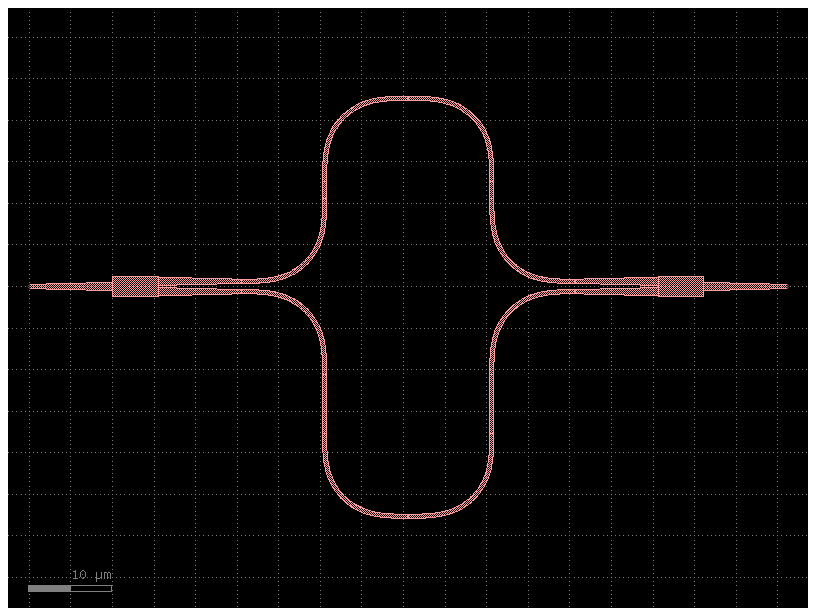

In [10]:
import gdsfactory as gf
c = gf.components.mzi()
c.plot()

In [11]:
import re
import sqlite3

# the user input should always include an operating wavelength for the device
user_input = "find a 1x2 mmi that operates at a wavelength of 1550nm."

parameters_dict = {}
parameters_dict_2 = {}
function_call = ""

def print_entry_for_id(id):
    function_call = ""
    # Connect to the SQLite database
    conn = sqlite3.connect("Devices-simulation.db")
    cursor = conn.cursor()

    # Retrieve the entry for the given ID
    cursor.execute(f"SELECT * FROM DevicesTable WHERE DeviceID = ?", (id,))
    entry = cursor.fetchone()

    if entry:
        # Get the column names
        cursor.execute(f"PRAGMA table_info(DevicesTable)")
        columns = [column[1] for column in cursor.fetchall()]

        # Print column = value format
        for column, value in zip(columns, entry):
            print(f"{column} = {value}")
            if column == "function_call":
                function_call = value
    else:
        print("No entry found for the given ID")
        

    # Close the connection
    conn.close()
    return function_call

def extract_id_from_string(input_string):
    # Split the input string by newline characters
    lines = input_string.strip().split('\n')
    
    # Iterate through each line
    for line in lines:
        # Check if the line contains '=' character
        if '=' in line:
            # Split the line by '=' and strip whitespace
            parts = line.split('=')
            if len(parts) < 2:
                # Invalid format, continue to the next line
                continue
            
            # Join the remaining parts with '=' except for the first one
            value_str = '='.join(parts[1:]).strip()

            try:
                # Try converting the value to an integer
                id_value = int(value_str)
                return id_value
            except ValueError:
                # Handle cases where the value is not an integer
                print("ID is not an integer value")
                return None

    # If no valid ID is found
    return None
    

def run_code(code_string):
    try:
        exec(code_string)
        result = "Success"
    except Exception as e:
        result = "Failed"
        print("Error:", e)
    return result

def extract_substring(input_str):
    pattern = r"\((.*?)\)"
    match = re.search(pattern, input_str)
    if match:
        return match.group(1)
    else:
        return None



while (True):

    sytem_prompt_2 = '''given the user input:{}, 

                        first find the name of device from one of the items in the below list that best matches the device name in the user input, 

                        ['Edge Coupler Silicon', 'MMI 1x2',   '50-50 Directional Coupler',  'MZI']

                        in the SQL database, retrieve only the 'DeviceID' that matches what the user wants 

                        it's important to note that you should ignore the user specified parameters of the device.

                        another important note is that when retrieving the ID, Type="device_name" where "device_name" comes from from the above list,
                        and wavelength >= "StartBandwidth" and wavelength <= "StopBandwidth", where "wavelength" comes from the user input, you should not include center wavelength when searching for the device
                        
                        your should also note that you should only retrieve one device, if there's multiple devices in the database that satisfy the above rules,
                        you should retrieve the device with MeanIL closest to 0, if there's no MeanIL, then always retrieve the device with smaller DeviceID
                    

                        remember to always apply these rules when you retrieve the device id, 
                        
                        output your response in the format of " DeviceID = ... " 
                        
                        you should replace ... with the 'DeviceID' number of the device


                        
                        lastly, note that if you can't find such device, simply output "none is found" and don't output "DeviceID = ..."
                        '''.format(user_input)
    response_2 = sql_query_engine.query(sytem_prompt_2)
    print(response_2)
    
    input_string = str(response_2)

    id_value = extract_id_from_string(input_string)
    if id_value is not None:
        print("Extracted ID:", id_value)
        # collect_data_given_id(id_value)
        print("these are all the specs of the device")
        function_call = print_entry_for_id(id_value)
        print("this is the code to create this device")
        print(function_call)

        print("This is the device found (or no device found). Do you want to continue? (y/n)")
        user_input_1 = input().lower()

        if user_input_1 == "n":
            print("searching the sql database again...")
            continue
        else:
            print("found device as a starting point")
            break
    else:
        print("Invalid ID number")
        print("these are all the specs of the device")
        function_call = print_entry_for_id(id_value)

        print("This is the device found (or no device found). Do you want to continue? (y/n)")
        user_input_1 = input().lower()

        if user_input_1 == "n":
            print("searching the sql database again...")
            continue
        else:
            print("finding other devices ")
            break


 Based on the instructions you've provided, I'll try to formulate a response. However, I should note that I can't actually execute the SQL query or access a real database, so this is a hypothetical response based on the information given.

The SQL query you've provided seems to be looking for a device of type 'MMI 1x2' with a StartBandwidth less than or equal to 1550 and a StopBandwidth greater than or equal to 1550, and then selecting the device with the smallest (or zero) MeanIL, or if there's no MeanIL, the one with the smallest DeviceID.

If a device is found, the response would be in the format "DeviceID = ...", where "..." is the DeviceID number. However, if no such device is found, the response should be "none is found".

Given the SQL query, if there is a device in the database that matches these criteria, the response would be "DeviceID = [DeviceID number]". If not, the response would be "none is found". 

Please note that the actual response would depend on the data in your d

In [12]:
# if the operating wavelength is outside of the device range, we will run simulate_component() to first get an educated guess from 
# the database, then run simulation

import sqlite3
import re

user_input = "find a 1x2 MMI that operates at a wavelength of 1600nm."
entry = ""
def simulate_component(user_input):
    system_prompt = '''given the user input:{},

                        only find the name of device from one of the items in the below list that best matches the device name in the user input, 

                        ['Edge Coupler Silicon', 'MMI 1x2',   '50-50 Directional Coupler',  'MZI']

                        your output should look like "device name = ...", and you should replace ... with one of the items in the list provided to you
                    '''.format(user_input)
    response = str(query_engine_vector_inst.query(system_prompt))
    
    print(response)
    lines = response.split('\n')

    # Looping through each line to find the first equal sign
    for line in lines:
        if '=' in line:
            # Splitting the line by the equal sign
            parts = line.split('=')
            # Extracting the first word after the equal sign
            device_name = parts[1].strip()
            print(device_name)
            break  # Stop after finding the first equal sign


    conn = sqlite3.connect("Devices-simulation.db")
    cursor = conn.cursor()

    while True:
        print("Enter the start wavelength of this device in nm")
        start_wavelength = float(input())

        print("Enter the stop wavelength of this device in nm")
        stop_wavelength = float(input())

        if start_wavelength < stop_wavelength:
            break
        else:
            print("Error: Start wavelength must be smaller than stop wavelength. Please re-enter.")

    # Retrieve the entry for the given ID
    cursor.execute(f"SELECT function_call FROM DevicesTable WHERE Type = ? ORDER BY ABS(?-StartBandwidth)+ABS(?-StopBandwidth) LIMIT 1", (device_name, start_wavelength, stop_wavelength))    
    entry = cursor.fetchone()[0]
    #print(entry)

    #print(modified_string)
    print("you should run this code:")
    return entry+"\nc.search_space()"





print(simulate_component(user_input))

 device name = MMI 1x2
MMI 1x2
Enter the start wavelength of this device in nm
Enter the stop wavelength of this device in nm
you should run this code:
c = mmi1x2(db="sims/Devices-simulation.db", wavelength_start=1.53, wavelength_stop=1.565,start_bandwidth=1.53, stop_bandwidth=1.565, Width_MMI=3.8, Length_MMI=12.8, Gap_MMI=0.25, Taper_Length=10.0, Taper_Width=1.4)
c.search_space()


In [13]:
user_input_3 = "there's no device with the wavelength I gave"

user_input_4 = "The insertion loss is too high for this device"

user_input_5 = "The bandwidth is too small for this device"
count = 0
while(True):
   print(count)
   count +=1
   sytem_prompt_4 = ''' given the user input here: {}, find which function to call from the context,

                     for example, if you select function 1, the output should be "simulate_component(user_input)"
                     if you select function 2, the output should be "optimize_IL(c)"

                  '''.format(user_input_4)
   response_4 = str(query_engine_vector_inst.query(sytem_prompt_4))
   #print(response_4)
   # Using regular expression to find the last string within quotes
   matches = re.findall(r'"([^"]*)"', response_4)

   if matches:
      last_string = matches[-1]
      print(last_string)
   else:
      print("No string within quotes found.")

0
scipyminopt(c)
1
scipyminopt(c)
2
scipyminopt(c)
3
scipyminopt(c)
4
scipyminopt(c)
5
scipyminopt(c)
6
scipyminopt(c)
7
scipyminopt(c)
8
scipyminopt(c)
9
scipyminopt(c)
10
scipyminopt(c)
11


KeyboardInterrupt: 